<a href="https://colab.research.google.com/github/Ankur-singh/personal_projects/blob/master/Notebooks/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GANs
A Generative Adversarial Network (GAN) is a technique in which two models are trained simultaneously: one specializes in creating fake data and other specializes in distinguishing between the real data and the fake data. The two models compete against each other, improving the quality of the generated data.

In [0]:
#%matplotlib inline
import os
import random

import torch
from torch import nn
from torch import optim 
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder, MNIST, FashionMNIST
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [8]:
# Setting random_seed
Seed = '42'
print("Random Seed: ", Seed)
random.seed(Seed)
torch.manual_seed(Seed)

Random Seed:  42


Setting all the variable in one place.

In [0]:
workers = 2 
batch_size = 64 
image_size = 64

channels = 3

latent_size = 84
feature_map_size = 48
num_epochs = 35

lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A small helper function to load data for us. It returns a *DataLoader*

In [0]:
def get_data(name):
    global num_epochs, channels
    if name.lower() == 'mnist':
        num_epochs = 25
        channels = 1
        tfms = transforms.Compose([
                       transforms.Resize(image_size),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,)),
                   ])
        dataset = MNIST('.', train=False, download=True, transform=tfms)
        return DataLoader(dataset, batch_size=batch_size,
                      shuffle=True, num_workers=workers)
        
    elif name.lower() == 'fashion':
        num_epochs = 25
        channels = 1
        tfms = transforms.Compose([
                       transforms.Resize(image_size),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,)),
                   ])
        dataset = FashionMNIST('.', train=False, download=True, transform=tfms)
        return DataLoader(dataset, batch_size=batch_size,
                      shuffle=True, num_workers=workers)
        
    elif name.lower() == 'pixel_ch':
        num_epochs = 35
        channels = 3
        tfms = transforms.Compose([
                       transforms.Resize(image_size),
                       transforms.CenterCrop(image_size),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ])
        dataset = ImageFolder(root='pixel_ch', transform=tfms)
        return DataLoader(dataset, batch_size=batch_size,
                              shuffle=True, num_workers=workers)

Some more helper functions to help us with Generator and Discriminator model

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator model         
class Generator(nn.Module):
    def __init__(self, channels, feature_map_size, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            nn.ConvTranspose2d( feature_map_size, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)
    
# Discriminator model         
class Discriminator(nn.Module):
    def __init__(self, channels, feature_map_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

![DCGAN Generator](https://pytorch.org/tutorials/_images/dcgan_generator.png)

lets load our data and visualize it.

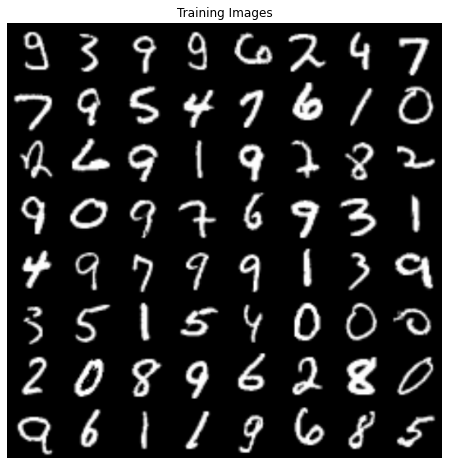

In [59]:
dataloader = get_data('mnist')

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [60]:
# Create the generator
netG = Generator(channels, feature_map_size, latent_size).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

print(netG)

Generator(
  (encoder): Sequential(
    (0): ConvTranspose2d(84, 384, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(48, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [61]:
netD = Discriminator(channels, feature_map_size).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (decoder): Sequential(
    (0): Conv2d(1, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Conv2d(384, 1, kernel_size=(4, 4), str

In [0]:
criterion = nn.BCELoss() 

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [63]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        label = ((1.05-0.95)*torch.rand((b_size, 1)) + 0.95).to(device)

        output = netD(real_cpu).view(-1)
        
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise)

        label = (0.1*torch.rand((b_size, 1))).to(device)

        output = netD(fake.detach()).view(-1)
        errD_fake =  criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        optimizerD.step()

        # Update G network
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/25][0/157]	Loss_D: 1.2171	Loss_G: 2.0366	D(x): 0.5804	D(G(z)): 0.3990 / 0.1663
[0/25][50/157]	Loss_D: 0.4213	Loss_G: 4.7324	D(x): 0.9311	D(G(z)): 0.1472 / 0.0164
[0/25][100/157]	Loss_D: 0.7408	Loss_G: 4.6968	D(x): 0.7252	D(G(z)): 0.0221 / 0.0148
[0/25][150/157]	Loss_D: 0.5383	Loss_G: 4.3694	D(x): 0.9051	D(G(z)): 0.2799 / 0.0206


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/25][0/157]	Loss_D: 0.3500	Loss_G: 3.2178	D(x): 0.9230	D(G(z)): 0.1218 / 0.0709
[1/25][50/157]	Loss_D: 0.5244	Loss_G: 4.3788	D(x): 0.9610	D(G(z)): 0.3105 / 0.0203
[1/25][100/157]	Loss_D: 0.5914	Loss_G: 4.4960	D(x): 0.9642	D(G(z)): 0.3460 / 0.0193
[1/25][150/157]	Loss_D: 1.3497	Loss_G: 0.0842	D(x): 0.4475	D(G(z)): 0.0447 / 0.9226
[2/25][0/157]	Loss_D: 0.4587	Loss_G: 2.7648	D(x): 0.8789	D(G(z)): 0.1663 / 0.0897
[2/25][50/157]	Loss_D: 0.7604	Loss_G: 2.0758	D(x): 0.6695	D(G(z)): 0.0263 / 0.1958
[2/25][100/157]	Loss_D: 0.3573	Loss_G: 2.5665	D(x): 0.9042	D(G(z)): 0.1074 / 0.1061
[2/25][150/157]	Loss_D: 0.8976	Loss_G: 6.9350	D(x): 0.9701	D(G(z)): 0.5253 / 0.0019
[3/25][0/157]	Loss_D: 0.8732	Loss_G: 0.9532	D(x): 0.6172	D(G(z)): 0.1573 / 0.4730
[3/25][50/157]	Loss_D: 0.3432	Loss_G: 2.4672	D(x): 0.8990	D(G(z)): 0.0929 / 0.1314
[3/25][100/157]	Loss_D: 0.6343	Loss_G: 2.4571	D(x): 0.8087	D(G(z)): 0.2102 / 0.1203
[3/25][150/157]	Loss_D: 0.6812	Loss_G: 2.4683	D(x): 0.8181	D(G(z)): 0.3026 / 0.1253
[

Lets look at the loss . . . 

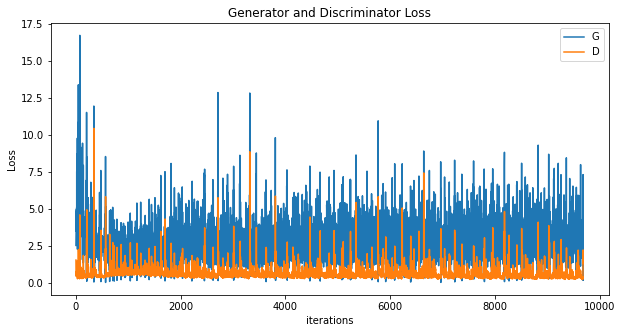

In [46]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

Generated image by our Generator model.

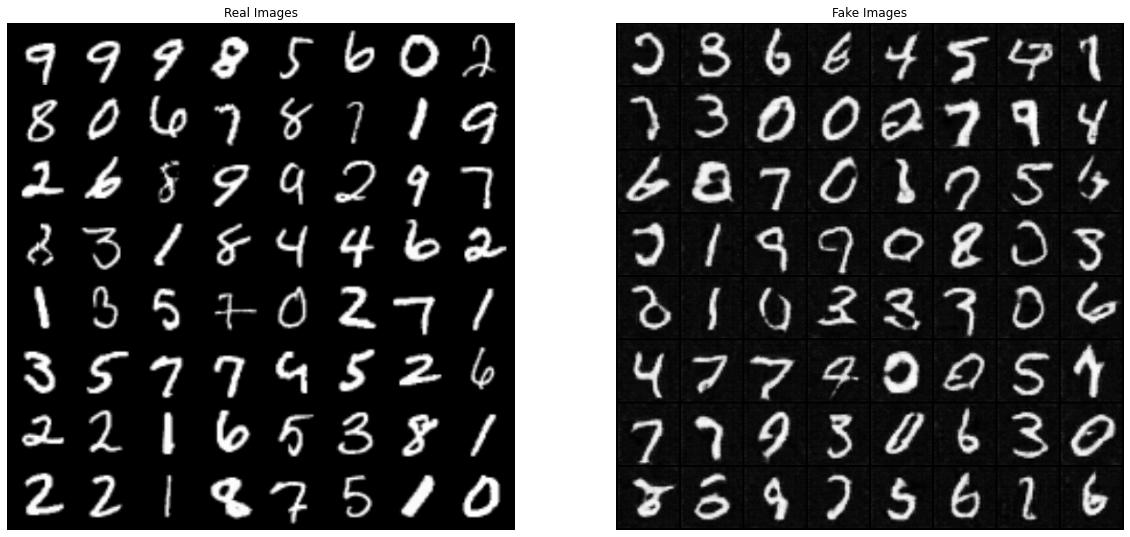

In [64]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
    
# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('mnist.png')

We can also look how our model progresses over the time. 

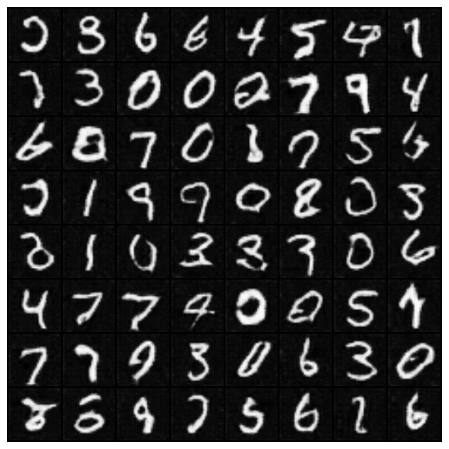

In [67]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Uncomment the below code if you want to save the animation as a video file (*.mp4* to be specific)

In [0]:
# # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save('mnist.mp4', writer=writer)

Here are some more generated images.

When you train the same model on pixel character. This is what you get.  

**Note:** you can simply update your `get_data(pixel_ch)` function in the above code and re-train the model.

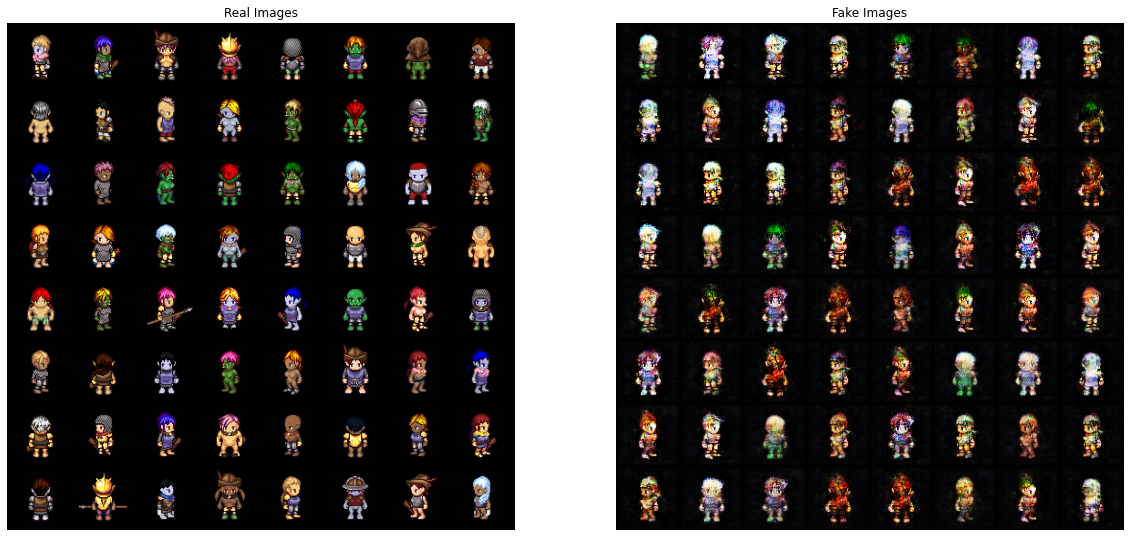

In [28]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
    
# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('pixel_ch.png')

When you train your model on *FashionMNIST*

**Note:** You can update your `get_data('fashion')`.

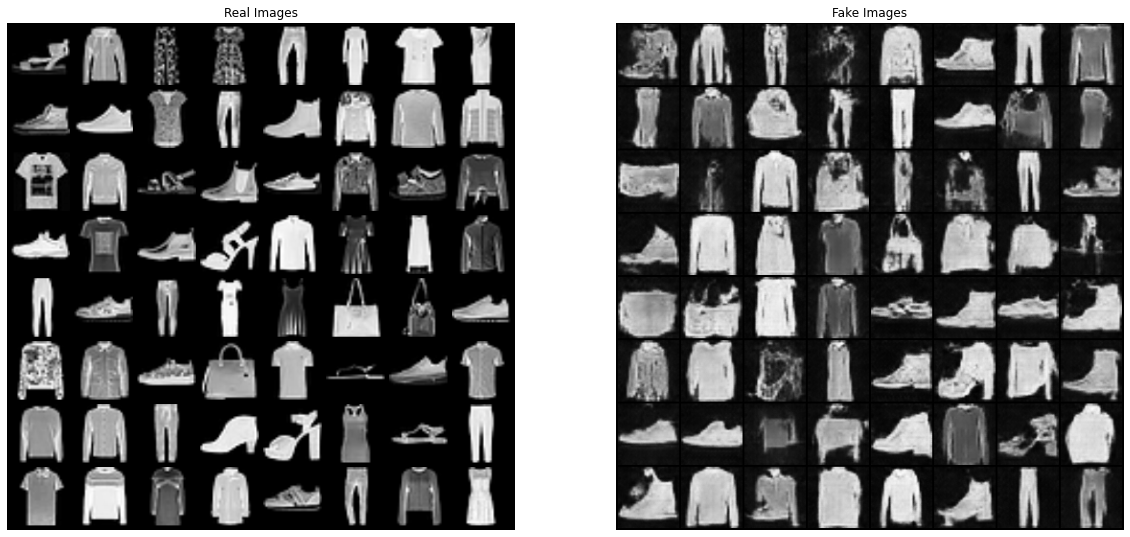

In [57]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
    
# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('fahion_mnist.png')

## PGGAN (Progressive GANs)
PGGANs are advanced GANs compared to DCGANs, and are capable of generating photorealistic images. A PGGAN trains the GAN network in multiple phases.

You don't have to implement it. You can directly use a pretrained model for generating some fake images. Follow [this](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/). 

In [74]:
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [0]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

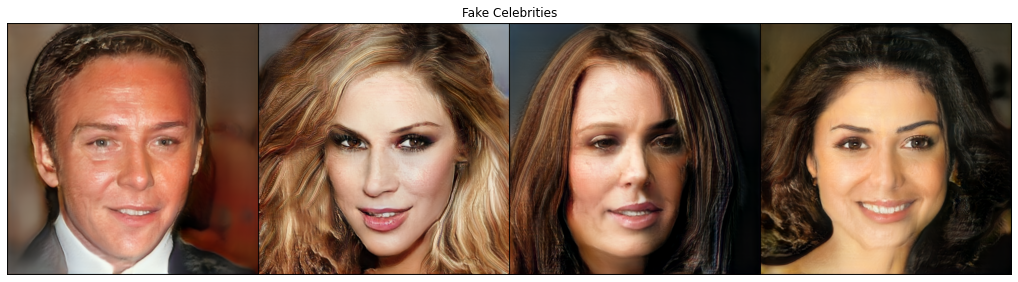

In [88]:
plt.figure(figsize=(18,6))
plt.axis("off")
plt.title("Fake Celebrities")
grid = vutils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy());
plt.savefig('fake_celeb.png')

If you are interested, you can also have a look at its implementation [here](https://github.com/nashory/pggan-pytorch).